In [2]:
# Data Preparation Libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import datetime

# Data Profiling
import pandas_profiling

# Plot and Visualisations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
%matplotlib inline

# Notebook settings
import warnings
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
warnings.filterwarnings('ignore')
import gc

# Modelling libraries
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [4]:
train = pd.read_csv(r'C:\Users\c026nedem\MyProjects\Home Credit\application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
test = pd.read_csv(r'C:\Users\c026nedem\MyProjects\Home Credit\application_test.csv')
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

# Feature Engineering on Numerical Variables

In [6]:
train.select_dtypes(include=np.number).columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [7]:
numeric_cols = train.select_dtypes(include=np.number).columns.to_list()
numeric_cols

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

## Missing Values


### Why is data missing?


#### Missing Completely at Random, MCAR:

A variable is missing completely at random (MCAR) if the probability of being missing is the same for all the observations. 
When data is MCAR, there is absolutely no relationship between the data missing and any other values, observed or missing, within the dataset. In other words, those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than other. If values for observations are missing completely at random, then disregarding those cases would not bias the inferences made.

#### Missing at Random, MAR: 

MAR occurs when there is a relationship between the propensity of missing values and the observed data. In other words, the probability of an observation being missing depends on available information (i.e., other variables in the dataset). For example, if men are more likely to disclose their weight than women, weight is MAR. The weight information will be missing at random for those men and women who do not disclose their weight, but as men are more prone to disclose it, there will be more missing values for women than for men.

In a situation like the above, if we decide to proceed with the variable with missing values (in this case weight), we might benefit from including gender to control the bias in weight for the missing observations.

#### Missing Not at Random, MNAR: 

Missing data is not at random (MNAR) when there is a mechanism or a reason why missing values are introduced in the dataset. For example, MNAR would occur if people failed to fill in a depression survey because of their level of depression. Here, the missing of data is related to the outcome, depression. Similarly, when a financial company asks for bank and identity documents from customers in order to prevent identity fraud, typically, fraudsters impersonating someone else will not upload documents, because they don't have them, because they are fraudsters. Therefore, there is a systematic relationship between the missing documents and the target we want to predict: fraud.

====================================================================================================

In [8]:
missing_values_table(train[numeric_cols])

Your selected dataframe has 106 columns.
There are 61 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
FLOORSMIN_MEDI,208642,67.8


In [9]:
#### Example of Missing Not at Random
train[['FLAG_OWN_CAR','OWN_CAR_AGE']].head()

,FLAG_OWN_CAR,OWN_CAR_AGE
0,N,NaN
1,N,NaN
2,Y,26.0
3,N,NaN
4,N,NaN


In [10]:
train[train['OWN_CAR_AGE'].isnull()][['FLAG_OWN_CAR','OWN_CAR_AGE']].head(10)

,FLAG_OWN_CAR,OWN_CAR_AGE
0,N,NaN
1,N,NaN
3,N,NaN
4,N,NaN
5,N,NaN
8,N,NaN
9,N,NaN
10,N,NaN
11,N,NaN
12,N,NaN


## Methods to input missing values

1. Drop rows from the dataset
2. Drop column from the dataset
3. Impute column with zero
4. Impute column with mean
5. Impute column with median
6. Impute column with arbitrary value

#### 1. Drop rows from the dataset

**Never do it!!!**

In [11]:
train.shape

(307511, 122)

In [12]:
train_null = train.dropna(subset=['OWN_CAR_AGE'], how='all')
train_null.shape

(104582, 122)

#### 2. Drop columns from the dataset

In [13]:
# method for feature selection - we will later disscuss

In [14]:
# drop columns with 90% nulls
print('Shape before:',train.shape)
train_null = train.loc[:, train.isnull().mean() < .60]
# drop columns with 90% nulls
print('Shape after:',train_null.shape)

Shape before: (307511, 122)
Shape after: (307511, 105)


#### 3. Impute column with zero

In [15]:
def impute_value(df, variable, value):

    return df[variable].fillna(value,inplace=False)

In [16]:
train['OWN_CAR_AGE_zero'] = impute_value(train, 'OWN_CAR_AGE', 0)

train[['FLAG_OWN_CAR','OWN_CAR_AGE','OWN_CAR_AGE_zero']].head(10)

,FLAG_OWN_CAR,OWN_CAR_AGE,OWN_CAR_AGE_zero
0,N,NaN,0.0
1,N,NaN,0.0
2,Y,26.0,26.0
3,N,NaN,0.0
4,N,NaN,0.0
5,N,NaN,0.0
6,Y,17.0,17.0
7,Y,8.0,8.0
8,N,NaN,0.0
9,N,NaN,0.0


#### 4. Impute column with mean or median

In [17]:
mean = train.OWN_CAR_AGE.mean()
mean

12.061090818687727

In [18]:
median = train.OWN_CAR_AGE.median()
median

9.0

In [19]:
def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [20]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
train['OWN_CAR_AGE_median'] = impute_na(train, 'OWN_CAR_AGE', median)

# now replace with the mean
train['OWN_CAR_AGE_mean'] = impute_na(train, 'OWN_CAR_AGE', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
train['OWN_CAR_AGE_mean'] = np.round(train['OWN_CAR_AGE_mean'], 1)

train[['FLAG_OWN_CAR','OWN_CAR_AGE','OWN_CAR_AGE_mean','OWN_CAR_AGE_median']].head(10)

,FLAG_OWN_CAR,OWN_CAR_AGE,OWN_CAR_AGE_mean,OWN_CAR_AGE_median
0,N,NaN,12.1,9.0
1,N,NaN,12.1,9.0
2,Y,26.0,26.0,26.0
3,N,NaN,12.1,9.0
4,N,NaN,12.1,9.0
5,N,NaN,12.1,9.0
6,Y,17.0,17.0,17.0
7,Y,8.0,8.0,8.0
8,N,NaN,12.1,9.0
9,N,NaN,12.1,9.0


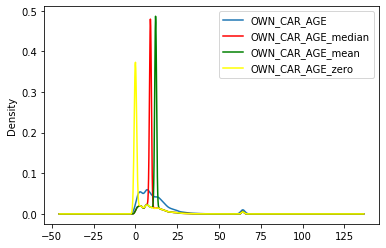

In [21]:
# we can see that the distribution has changed 
# with now more values accumulating towards the median
# or median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['OWN_CAR_AGE'].plot(kind='kde', ax=ax)

# variable imputed with the median
train['OWN_CAR_AGE_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
train['OWN_CAR_AGE_mean'].plot(kind='kde', ax=ax, color='green')

# variable imputed with the mean
train['OWN_CAR_AGE_zero'].plot(kind='kde', ax=ax, color='yellow')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

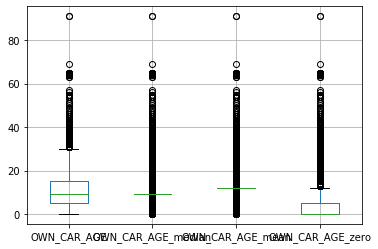

In [22]:
# mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
train[['OWN_CAR_AGE', 'OWN_CAR_AGE_median', 'OWN_CAR_AGE_mean','OWN_CAR_AGE_zero']].boxplot()

#### 6. Impute column with arbitrary value

In [23]:
train['OWN_CAR_AGE_arbit'] = impute_value(train, 'OWN_CAR_AGE', 999)

train[['FLAG_OWN_CAR','OWN_CAR_AGE','OWN_CAR_AGE_arbit']].head(10)

,FLAG_OWN_CAR,OWN_CAR_AGE,OWN_CAR_AGE_arbit
0,N,NaN,999.0
1,N,NaN,999.0
2,Y,26.0,26.0
3,N,NaN,999.0
4,N,NaN,999.0
5,N,NaN,999.0
6,Y,17.0,17.0
7,Y,8.0,8.0
8,N,NaN,999.0
9,N,NaN,999.0


#### Finaly Imputing NULLS

In [25]:
cols_zero = ['OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

cols_median = [ 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',]

In [28]:
# replace all nulls with median from train
for column in cols_median:
    train[column].fillna(train[column].median(),inplace=True)
    train[column].fillna(train[column].median(),inplace=True)

# replace all nulls with zero
for column in cols_zero:
    train[column].fillna(0,inplace=True)
    train[column].fillna(0,inplace=True)

In [29]:
missing_values_table(train[cols_zero])

Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Outliers

An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. In a sense, this definition leaves it up to the analyst (or a consensus process) to decide what will be considered abnormal. Before abnormal observations can be singled out, it is necessary to characterize normal observations.

<img src="https://miro.medium.com/max/8000/1*0MPDTLn8KoLApoFvI0P2vQ.png" style="width:500px;height:300px"/>

In [91]:
# function for alerts theshold calulation
def outlier_values(data, var):
    field = data[var]
    print(var, ' min value: ', field.min())
    print(var, ' median value: ', field.median())
    IQR = field.quantile(0.75) - field.quantile(0.25)
    Upper_fence = field.quantile(0.75) + (IQR * 1.5)
    print()
    print('*'*40)
    print()
    print(var, ' upper outlier range: ', Upper_fence)
    Upper_fence = field.quantile(0.75) + (IQR * 3)
    print()
    print('*'*40)
    print()
    print(var, ' extreme upper outlier range: ', Upper_fence)
    print()
    print('*'*40)
    print()
    print(var, ' max value: ', field.max())
    print('')

In [92]:
outlier_values(train, 'AMT_INCOME_TOTAL')

AMT_INCOME_TOTAL  min value:  25650.0
AMT_INCOME_TOTAL  median value:  147150.0

****************************************

AMT_INCOME_TOTAL  upper outlier range:  337500.0

****************************************

AMT_INCOME_TOTAL  extreme upper outlier range:  472500.0

****************************************

AMT_INCOME_TOTAL  max value:  117000000.0



In [93]:
train[train['AMT_INCOME_TOTAL'] > 472500]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_zero,OWN_CAR_AGE_median,OWN_CAR_AGE_mean,OWN_CAR_AGE_arbit
51,100059,0,Cash loans,M,Y,Y,1,540000.0,675000.0,34596.0,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.026392,-18632,-6977,-3904.0,-1937,7.0,1,1,0,1,1,0,Managers,3.0,2,2,TUESDAY,10,0,0,0,0,0,0,Services,0.311510,0.713355,0.309275,0.5309,0.2491,0.9811,0.7416,NaN,0.88,0.3793,0.4583,0.0000,0.3977,NaN,0.5878,NaN,0.0487,0.5410,0.2585,0.9811,0.7517,NaN,0.8862,0.3793,0.4583,0.0000,0.4067,NaN,0.6124,NaN,0.0516,0.5361,0.2491,0.9811,0.7451,NaN,0.88,0.3793,0.4583,0.0000,0.4046,NaN,0.5983,NaN,0.0498,NaN,block of flats,0.5149,Panel,No,2.0,0.0,2.0,0.0,-1285.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,3.0,7.0,7.0,7.0,7.0
59,100070,0,Cash loans,M,Y,Y,0,540000.0,1227901.5,46899.0,1129500.0,Unaccompanied,Working,Higher education,Widow,House / apartment,0.032561,-20544,-2091,-6846.0,-566,2.0,1,1,1,1,0,0,Managers,1.0,1,1,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,NaN,0.653597,0.339288,0.0256,0.0000,0.9354,0.1160,0.0076,0.00,0.1172,0.1000,0.1417,0.0664,0.0202,0.0305,0.0039,0.0084,0.0063,0.0000,0.9136,0.0000,0.0006,0.0000,0.0690,0.0833,0.1250,0.0819,0.0055,0.0072,0.0000,0.0000,0.0104,0.0000,0.9136,0.0000,0.0015,0.00,0.0690,0.0833,0.1250,0.0815,0.0086,0.0070,0.0039,0.0013,reg oper account,block of flats,0.0058,"Stone, brick",No,0.0,0.0,0.0,0.0,-1377.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
319,100366,0,Revolving loans,M,Y,Y,0,765000.0,1350000.0,67500.0,1350000.0,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.002506,-11788,-3144,-5643.0,-3962,3.0,1,1,0,1,0,0,Managers,1.0,2,2,THURSDAY,7,0,0,0,1,1,0,Business Entity Type 3,0.421765,0.765981,0.511892,0.0330,0.0374,0.9831,0.7688,

### Feature Scalling

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

- MinMaxScaler
- StandardScaler

<img src="https://miro.medium.com/max/2400/1*bbZowuePbbu93KjYbSZRNw.jpeg" style="width:500px;height:300px"/>

In [47]:
all_numeric_features = cols_zero + cols_median
all_numeric_features

['OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'T

In [33]:
# this scales the features between 0 and 1.
scaler = MinMaxScaler() # create an instance
train_scaled = scaler.fit_transform(train[all_numeric_features]) #  fit  the scaler to the train set and then transform it
test_scaled = scaler.transform(test[all_numeric_features]) # transform (scale) the test set

In [55]:
train_scaled

array([[0.        , 0.05      , 0.0862549 , ..., 0.08333333, 0.09003159,
        0.07744108],
       [0.        , 0.1       , 0.32332985, ..., 0.        , 0.13292383,
        0.27160494],
       [0.28571429, 0.05      , 0.        , ..., 0.        , 0.02002457,
        0.02356902],
       ...,
       [0.        , 0.05      , 0.77285965, ..., 0.        , 0.11061776,
        0.13580247],
       [0.        , 0.1       , 0.        , ..., 0.        , 0.07249912,
        0.06958474],
       [0.        , 0.1       , 0.76292218, ..., 0.        , 0.18525799,
        0.15824916]])

In [51]:
train['OWN_CAR_AGE']

0          0.0
1          0.0
2         26.0
3          0.0
4          0.0
          ... 
307506     0.0
307507     0.0
307508     0.0
307509     0.0
307510     0.0
Name: OWN_CAR_AGE, Length: 307511, dtype: float64

In [54]:
train_scaled[:,0]

array([0.        , 0.        , 0.28571429, ..., 0.        , 0.        ,
       0.        ])